# Rejecting High Efficiency Muons

In this notebook, I want to reject the high efficiency Muons and re-plot the ROC curve for e vs gamma for the 4-class models. 

Here is an outline for how to do this:
1. Determine the thr, tpr, and fpr for Electron/Gamma vs Muon case
2. Find the index in the tpr list which corresponds to 98% efficiency 
3. Use the index from the tpr list to find the threshold in the thr list 
4. Remove events which have a Electron/Gamma score below that threshold 
5. Recalculate the tpr, thr, and fpr for the Electron vs Gamma case 
6. Determine the adjustment constant 
7. Multiply the tpr by the adjustment constant 
8. Re-plot the Electron vs Gamma ROC curve 

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
sys.path.append("..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.plot_utils import plot_classifier_response, plot_reduced_classifier_response

In [4]:
label_dict         = {"$\gamma$":0, "$e$":1, "$\mu$":2, '$\pi^0$':3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:'$\pi^0$'}

muon_softmax_index_dict = {"non-mu":0, "mu":1}

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

##  Load 2-class models and the associated data

In [5]:
locs_2_class = ['/home/hlahiouel/WatChMaL/outputs/2021-03-10/12-07-03/outputs', '/home/hlahiouel/WatChMaL/outputs/2021-03-10/12-14-45/outputs'] 

titles_2_class = ['2 Class - Barrel Fix','2 Class - Extra Indices - Barrel Fix']

linecolor_2_class = [c[0] for _ in locs_2_class]
linestyle_2_class = ['-' for _ in locs_2_class]

raw_output_softmax_2_class = [np.load(loc + "/softmax.npy") for loc in locs_2_class]

raw_actual_labels_2_class  = [np.load(loc + "/labels.npy") for loc in locs_2_class]

raw_actual_indices_2_class = [np.load(loc + "/indices.npy") for loc in locs_2_class]

## Load 3-class model and the associated data

In [6]:
locs_3_class = ['/home/hlahiouel/WatChMaL/outputs/2021-03-10/12-23-38/outputs'] 

titles_3_class = ['3 Class - Barrel Fix']

linecolor_3_class = [c[1] for _ in locs_3_class]
linestyle_3_class = ['-' for _ in locs_3_class]

raw_output_softmax_3_class = [np.load(loc + "/softmax.npy") for loc in locs_3_class]

raw_actual_labels_3_class  = [np.load(loc + "/labels.npy") for loc in locs_3_class]

raw_actual_indices_3_class = [np.load(loc + "/indices.npy") for loc in locs_3_class]

## Load 4-class model and the associated data

In [7]:
locs_4_updated_class = ['/home/hlahiouel/WatChMaL/outputs/2021-03-01/12-52-40/outputs']

titles_4_updated_class = ['4 Class Run 1 - Barrel Fix ']

linecolor_4_updated_class = [c[2] for _ in locs_4_updated_class]
linestyle_4_updated_class = ['-' for _ in locs_4_updated_class]

raw_output_softmax_4_updated_class = [np.load(loc + "/softmax.npy") for loc in locs_4_updated_class]

raw_actual_labels_4_updated_class  = [np.load(loc + "/labels.npy") for loc in locs_4_updated_class]

print(raw_actual_labels_4_updated_class)

raw_actual_indices_4_updated_class = [np.load(loc + "/indices.npy") for loc in locs_4_updated_class]

[array([1, 1, 1, ..., 3, 3, 3])]


In [8]:
titles = titles_2_class + titles_4_updated_class

linecolor = linecolor_2_class + linecolor_4_updated_class
linestyle = linestyle_2_class + linestyle_4_updated_class

softmaxes = raw_output_softmax_2_class + raw_output_softmax_4_updated_class
labels    = raw_actual_labels_2_class + raw_actual_labels_4_updated_class

In [9]:
for q in range(len(softmaxes)):
    softmax = softmaxes[q]
    print(softmax.shape)

(2104832, 2)
(2104832, 2)
(3721728, 4)


## Find fpr, tpr, and thr for Electron/Gamma vs Muon 

In [10]:
four_class_softmax = [softmaxes[2]] # Softmaxes for the 4-class model

In [11]:
four_class_labels = [labels[2]] # Labels for the 4-class model 

In [12]:
collapsed_class_scores_list, collapsed_class_labels_list = multi_collapse_test_output(four_class_softmax, four_class_labels, label_dict, ignore_type='$\gamma$',threshold="$\pi^0$")

collapsed_class_labels_list = [collapsed_class_labels - 1 for collapsed_class_labels in collapsed_class_labels_list]

collapsed_class_scores_list = [collapsed_class_scores[:, 1:] for collapsed_class_scores in collapsed_class_scores_list]

In [13]:
print(collapsed_class_scores_list[0].shape)

(1699058, 2)


In [14]:
# Computes the ROC curve for the e/gamma vs muon case 

fprs, tprs, thrs = multi_compute_roc(collapsed_class_scores_list, collapsed_class_labels_list, 
                                                         true_label=muon_softmax_index_dict["non-mu"], 
                                                         false_label=muon_softmax_index_dict["mu"],
                                                         normalize=True)

In [15]:
four_class_tpr = tprs[0] # Loads the true-positive rate (aka. efficiency) for the e/gamma vs muon 

In [16]:
four_class_thr = thrs[0] # Loads the thresholds for the e/gamma vs muon

## Find the index corresponding to the efficiency we want 

In [17]:
efficiency = 0.98 # The efficiency we want 
tolerance = 0.0001 # How much error we are willing to tolerate 

# This loop searches through the tpr to find the efficiency closest to the one we want

for i in range(len(four_class_tpr)): 
    if (four_class_tpr[i] >= (efficiency-tolerance)) and (four_class_tpr[i] <= efficiency+tolerance):
        print(four_class_tpr[i],i)

0.9799367870065359 692591
0.9799367870065359 692592
0.979941554200613 692593
0.979941554200613 692594
0.9799625298545529 692595
0.9799625298545529 692596
0.9799768314367846 692597
0.9799768314367846 692598
0.9799806451920464 692599
0.9799806451920464 692600
0.9800102017953253 692601
0.9800102017953253 692602
0.9800283171328188 692603
0.9800283171328188 692604
0.9800445255926814 692605
0.9800445255926814 692606
0.980069315001883 692607
0.980069315001883 692608
0.9800750356347757 692609
0.9800750356347757 692610
0.9800778959512221 692611
0.9800778959512221 692612


In [18]:
threshold_index = 692601 # Index corresponding to the efficiency we want 

In [19]:
threshold = four_class_thr[threshold_index] # Finds the threshold we need in the threshold data 

In [20]:
print(threshold)

0.3210533791978776


## Remove events which are below the threshold 

In [21]:
four_class_softmax = softmaxes[2] # Softmaxes for the 4-class model

In [22]:
four_class_labels = labels[2] # Labels for the 4-class model 

In [23]:
print(four_class_labels)

[1 1 1 ... 3 3 3]


In [24]:
print(np.where(four_class_labels == 1)[0])

[      0       1       2 ... 1048832 1048833 1048834]


In [25]:
print(np.where(four_class_labels == 0)[0])

[1048835 1048836 1048837 ... 2105211 2105212 2105213]


In [26]:
idxs = [] # List of indices 

# This loop finds the indices of the softmax data which have a e+gamma score below the threshold  

for j in range(len(four_class_softmax)):
    norm_factor = four_class_softmax[j,0]+four_class_softmax[j,1]+four_class_softmax[j,3]
    normalized_probability = (four_class_softmax[j,0]+four_class_softmax[j,1])/norm_factor
    if normalized_probability <= threshold:
        idxs.append(j)
        
idxs = np.array(idxs)

In [27]:
print(len(idxs))

803375


In [28]:
# This cell keeps track of the kind of events that are removed 

event_list = []

for w in idxs:
    event_list.append(four_class_labels[w])
    
event_list = np.array(event_list)

gamma_events = []

e_events = []

muon_events = []

pion_events= []

for r in event_list:
    if r == 0:
        gamma_events.append(r)
    if r == 1:
        e_events.append(r)
    if r == 2:
        muon_events.append(r)
    if r == 3:
        pion_events.append(r)

print("Removed gamma events =", len(gamma_events))
print("Removed electron events =", len(e_events))
print("Removed muon events =", len(muon_events))
print("Removed pion events =", len(pion_events))

Removed gamma events = 27412
Removed electron events = 20966
Removed muon events = 489
Removed pion events = 754508


## Filter out Electron and Gamma events from 2-class model 

In [29]:
last_gamma_event = np.where(four_class_labels == 0)[0][-1]

In [30]:
print(last_gamma_event)

2105213


In [31]:
two_class_softmax = softmaxes[0]

In [32]:
two_class_idxs = []

for e in range(len(idxs)):
    if idxs[e] <= len(two_class_softmax):
        two_class_idxs.append(idxs[e])
 
two_class_idxs = np.array(two_class_idxs)

In [33]:
print(len(two_class_idxs))

48368


In [34]:
new_two_class_softmax = np.delete(two_class_softmax,two_class_idxs,axis=0)

In [35]:
two_class_labels = labels[0]

In [36]:
new_two_class_labels = np.delete(two_class_labels,two_class_idxs)

In [37]:
two_class_extra_softmax = softmaxes[1]

In [38]:
new_two_class_extra_softmax = np.delete(two_class_extra_softmax,two_class_idxs,axis=0)

In [39]:
two_class_extra_labels = labels[1]

In [40]:
new_two_class_extra_labels = np.delete(two_class_extra_labels,two_class_idxs)

## Create new softmax data and labels 

In [41]:
# This cell deletes events from the softmax and labels which have a e+gamma score below the threshold 

new_softmax = np.delete(four_class_softmax,idxs,axis=0)

new_labels = np.delete(four_class_labels,idxs)

In [42]:
print(new_softmax.shape)
print(new_labels.shape)

(2918353, 4)
(2918353,)


In [43]:
softmaxes += [new_softmax, new_two_class_softmax, new_two_class_extra_softmax]
labels += [new_labels, new_two_class_labels, new_two_class_extra_labels]
titles += ["4-Class - Rejected Pions with 98% efficiency threshold", "2-class - Removed Events", "2-class - Extra Data - Removed Events"]
linecolor += [c[3],c[4],c[5]]
linestyle += ['-','-','-']

In [ ]:
softmaxes = [new_softmax, new_two_class_softmax, new_two_class_extra_softmax]
labels = [new_labels, new_two_class_labels, new_two_class_extra_labels]
titles = ["4-Class - Rejected Pions with 98% efficiency threshold", "2-class - Removed Events", "2-class - Extra Data - Removed Events"]
linecolor = [c[3],c[4],c[5]]
linestyle = ['-','-','-']

## Determine adjustment factor

In [44]:
num_electron_events_subset = np.where(new_labels == 1)

In [45]:
num_electron_events_subset = len(num_electron_events_subset[0]) # Number of electron events in the new subset 

In [46]:
print(num_electron_events_subset)

1027869


In [47]:
num_electron_events_overall = np.where(four_class_labels == 1)

In [48]:
num_electron_events_overall = len(num_electron_events_overall[0]) # Number of electron events before removal  

In [49]:
print(num_electron_events_overall)

1048835


In [50]:
num_gamma_events_subset = np.where(new_labels == 0)

In [51]:
num_gamma_events_subset = len(num_gamma_events_subset[0])

In [52]:
print(num_gamma_events_subset)

1028967


In [53]:
num_gamma_events_overall = np.where(four_class_labels == 0)

In [54]:
num_gamma_events_overall = len(num_gamma_events_overall[0])

In [55]:
print(num_gamma_events_overall)

1056379


In [56]:
# Used to adjust the tpr for the 4-class model with the removed events 
    
tpr_adjustment_constant = num_electron_events_subset / num_electron_events_overall

In [57]:
print(tpr_adjustment_constant)

0.9800102017953253


In [58]:
# Used to adjust the fpr for the 4-class model with the removed events 

fpr_adjustment_constant = num_gamma_events_subset / num_gamma_events_overall

In [59]:
print(fpr_adjustment_constant)

0.9740509798093298


## Modify the tpr and fpr 

In [60]:
# Calculates the ROC curve for e vs gamma based on the updated softmaxes and labels 

fprs, tprs, thrs = multi_compute_roc(softmaxes, labels, 
                                                     true_label=label_dict["$e$"], 
                                                     false_label=label_dict["$\gamma$"],
                                                     normalize=True)

In [61]:
for i,g in enumerate(softmaxes):
    if i >= 3:
        tprs[i] = tprs[i] * tpr_adjustment_constant
        fprs[i] = fprs[i] * fpr_adjustment_constant

In [ ]:
for i,g in enumerate(softmaxes):
    tprs[i] = tprs[i] * tpr_adjustment_constant
    fprs[i] = fprs[i] * fpr_adjustment_constant

In [ ]:
linecolor[1] = c[6]

## Plot ROC e vs gamma with Normalization 

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])
../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])


[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


../WatChMaL/analysis/plot_utils.py:620: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(ylim[0],ylim[1])


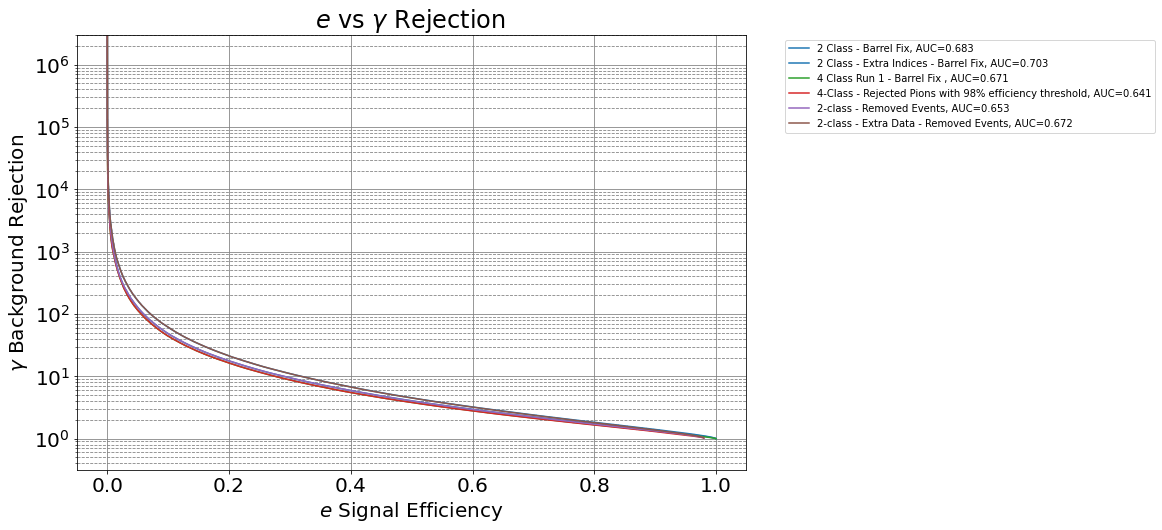

In [62]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[0,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]
[<AxesSubplot:title={'center':'$e$ vs $\\gamma$ Rejection '}, xlabel='$e$ Signal Efficiency', ylabel='$\\gamma$ Background Rejection'>]


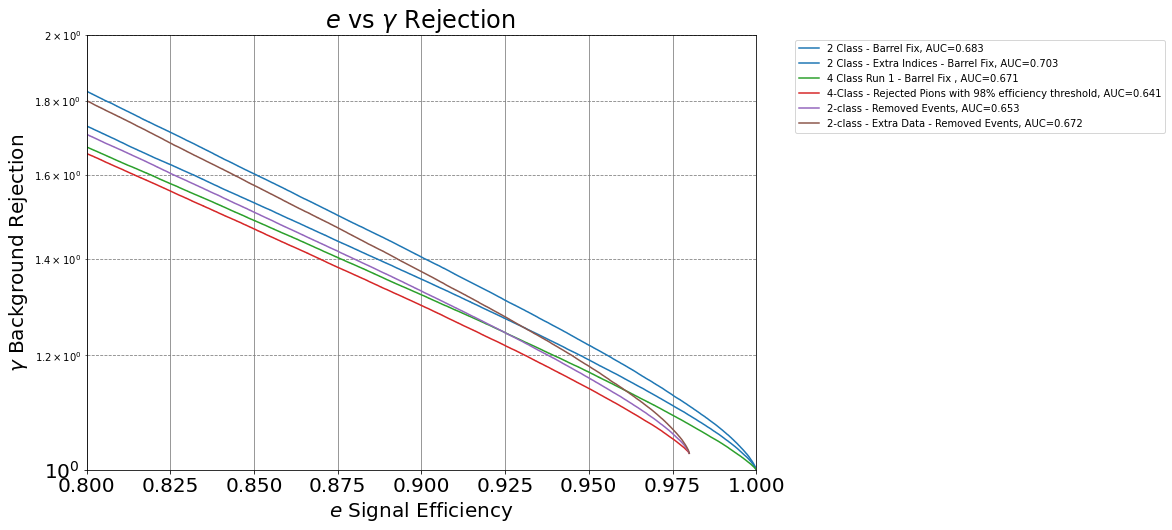

In [63]:
figs = multi_plot_roc(fprs, tprs, thrs, "$e$", "$\gamma$", 
                      fig_list=[1], 
                      xlims=[[0.8,1.0]],ylims=[[1e0,2e0]],
                      linestyles=linestyle,linecolors=linecolor, 
                      plot_labels=titles, show=False)

## Likelihood Plots 

In [ ]:
# Plot likelihood plot for 2-classes with approximately 3-million events 
'''
plot_reduced_classifier_response(softmaxes[0], labels[0],
                                          comparisons_list = [{'independent':['$\gamma$'],
                                                              'dependent':['$e$',"$\gamma$"]},
                                                             {'independent':['$e$'],
                                                              'dependent':['$e$',"$\gamma$"]}
                                                             ],
                                         label_dict=label_dict,
                                         linestyles=linestyle,
                                         title=titles[0],
                                         normalize=True
                                         )
'''

In [ ]:
# Plot likelihood plot for 3-classes without the rejected Muons 
'''
plot_reduced_classifier_response(softmaxes[2], labels[2],
                                          comparisons_list = [{'independent':['$\gamma$'],
                                                              'dependent':['$e$',"$\gamma$"]},
                                                             {'independent':['$e$'],
                                                              'dependent':['$e$',"$\gamma$"]}
                                                             ],
                                         label_dict=label_dict,
                                         linestyles=linestyle,
                                         title=titles[2],
                                         normalize=True
                                         )
'''

In [ ]:
# Plot likelihood plot for 3-classes with the rejected Muons 
'''
plot_reduced_classifier_response(softmaxes[7], labels[7],
                                          comparisons_list = [{'independent':['$\gamma$'],
                                                              'dependent':['$e$',"$\gamma$"]},
                                                             {'independent':['$e$'],
                                                              'dependent':['$e$',"$\gamma$"]}
                                                             ],
                                         label_dict=label_dict,
                                         linestyles=linestyle,
                                         title=titles[7],
                                         normalize=True
                                         )
                                         
'''